# Predicting the Number of Airline Passengers

The AirPassengers dataset is a time series representing the monthly number (in thousands) of international airline passengers from January 1949 to December 1960. I look for an appropriate model by analyzing the ACF and PACF, and evaluating model performance using AIC.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
import warnings
warnings.filterwarnings(action='once')

%matplotlib inline

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
parse_date = lambda d : dt.datetime.strptime(d, '%Y-%m')
ts = pd.read_csv('https://raw.githubusercontent.com/AtanasiuDemian/AtanasiuDemian.github.io/master/Data/AirPassengers.csv',
                 index_col='Month', date_parser=parse_date)

ts.rename(columns={'#Passengers':'Passengers'}, inplace=True)
ts.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0,0.5,'Passengers')

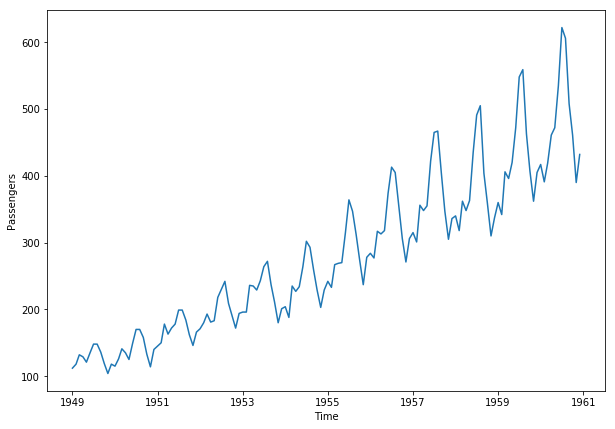

In [3]:
# Plot the time series
plt.figure(figsize=(10,7))
plt.plot(ts)
plt.xlabel('Time')
plt.ylabel('Passengers')

The series exhibits strong annual seasonality and an upward trend. It is clearly not stationary, hence it needs to be differenced.

A series is (weakly) stationary when:

1) Mean is constant.

2) Autocovariance depends only on the lag. This condition also implies that the variance is constant.

In this dataset variance increases with time, hence I should apply a function that 'penalizes' a positive increase, such as the logarithm function.

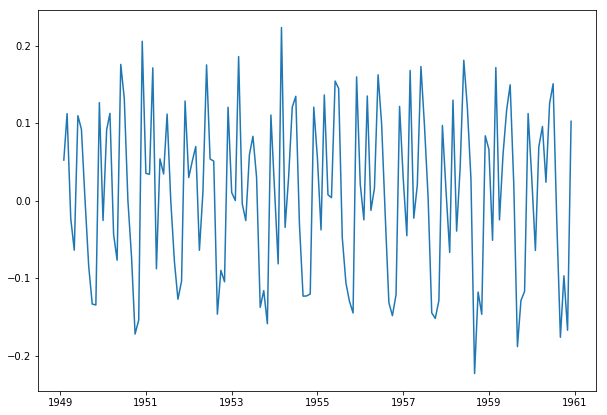

In [4]:
log_ts = np.log(ts)
log_ts_diff1 = log_ts - log_ts.shift() #first order differencing
log_ts_diff1.dropna(inplace=True)

plt.figure(figsize=(10,7))
plt.plot(log_ts_diff1)

The new series looks stationary. I will fit a time series model on the data up until December 1958, and use this model to 'forecast' the number of passengers in 1959 and 1960.

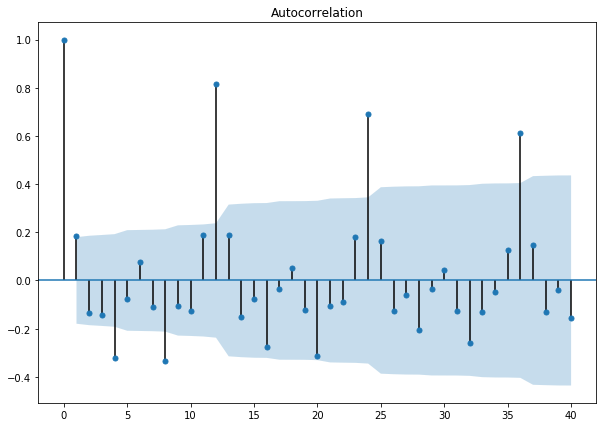

In [5]:
# Plot ACF
fig,ax = plt.subplots(figsize=(10,7))
tsaplots.plot_acf(log_ts_diff1[:'1958-12-01'], lags=40, ax=ax);

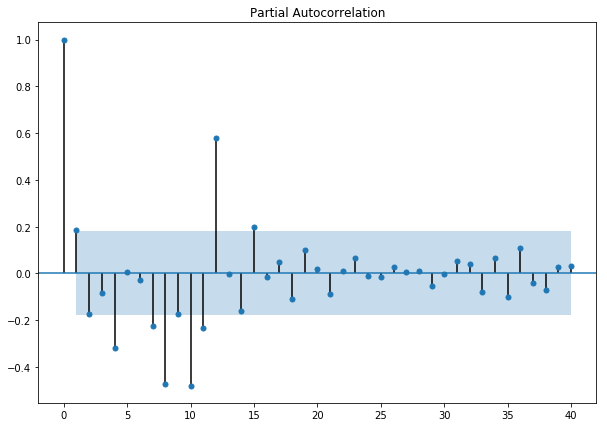

In [6]:
# Plot PACF
fig,ax = plt.subplots(1,1,figsize=(10,7))
tsaplots.plot_pacf(log_ts_diff1[:'1958-12-01'], lags=40, ax=ax);

The $95\%$ confidence interval is shown by the blue region in the plot above, and it is given approximately by $\pm \frac{2}{\sqrt{n}}$, where $n$ is the size of the time series (though it seems the confidence interval for ACF is computed differently in statsmodels). The PACF shows a 'cut-off' at lag 12, even though some of the values for smaller lags are within the confidence interval. The cut-off suggests an AR process. The original series has been differenced, hence I will have an ARIMA process.

I will fit several ARIMA models that comprise only auto-regressive processes, and assess the AIC of the models.

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5,1,'AIC for ARIMA(p,1,0)')

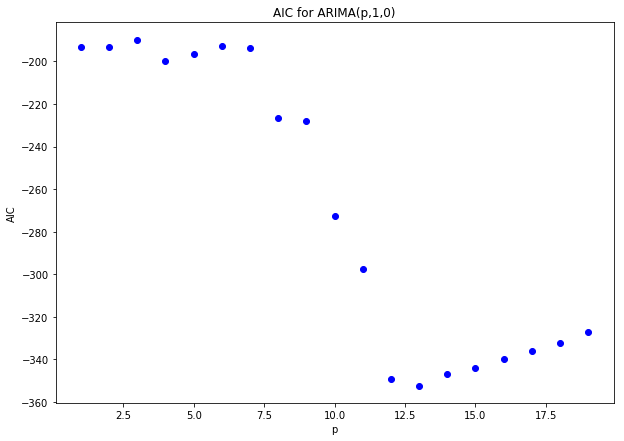

In [7]:
AR_orders=list(range(1,20))
AIC=[]
for p in AR_orders:
    aic_model = ARIMA(log_ts[:'1958-12-01'], order=(p,1,0))
    aic_model_results=aic_model.fit(method='css', disp=-1)
    AIC.append(aic_model_results.aic)

plt.figure(figsize=(10,7))
plt.plot(AR_orders, AIC, 'bo')
plt.xlabel('p')
plt.ylabel('AIC')
plt.title('AIC for ARIMA(p,1,0)')

By the looks of the AIC graph, fitting an ARIMA(12,1,0) model suffices to explain much of the variability in the data; adding more terms does not improve the model much. Let $\{Z_{t}\}_{t \in \mathbb{Z}} \stackrel{iid}{\sim} \mathcal{N}(0, \sigma^2)$ be a purely random process, with $\sigma^2$ unknown, and $\{X_{t}\}$ be the original time series. An ARIMA(12,1,0), with constant $\mu$, is given by:

$$ W_{t} :=  \nabla X_{t} = X_{t} - X_{t-1} $$ 

$$ W_{t} = \mu + \alpha_{1} W_{t-1} + \alpha_{2} W_{t-2} + ... + \ \alpha_{12} W_{t-12} + Z_{t}$$ 

In [8]:
ar_model = ARIMA(log_ts[:'1958-12-01'], order=(12,1,0))
ar_model = ar_model.fit(method='css', disp=-1)

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [9]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Passengers   No. Observations:                  119
Model:                ARIMA(12, 1, 0)   Log Likelihood                 188.702
Method:                           css   S.D. of innovations              0.041
Date:                Fri, 23 Feb 2018   AIC                           -349.404
Time:                        23:05:33   BIC                           -311.984
Sample:                    02-01-1950   HQIC                          -334.234
                         - 12-01-1958                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0102      0.001      7.725      0.000       0.008       0.013
ar.L1.D.Passengers     -0.2064      0.074     -2.779      0.007      -0.352      -0.061
ar.L2.D.Passengers     -0.2771      0.076     -3.626      0.000      -0.427      -0.127
ar.L3.D.Passengers     -0.2096      0.075     -2.792      0.006      -0.357      -0.062
ar.L4.D.Passengers     -0.3093      0.078     -3.990      0.000      -0.461      -0.157
ar.L5.D.Passengers     -0.1874      0.076     -2.467      0.015      -0.336      -0.038
ar.L6.D.Passengers     -0.2736      0.074     -3.674      0.000      -0.420      -0.128
ar.L7.D.Passengers     -0.2147      0.076     -2.836      0.006      -0.363      -0.066
ar.L8.D.Passengers     -0.3281      0.077     -4.282      0.000      -0.478      -0.178
ar.L9.D.Passengers     -0.2098      0.077     -2.708      0.008      -0.362      -0.058
ar.L10.D.Passengers    -0.2817      0.077     -3.650      0.000      -0.433      -0.130
ar.L11.D.Passengers    -0.1750      0.078     -2.247      0.027      -0.328      -0.022
ar.L12.D.Passengers     0.6282      0.078      8.077      0.000       0.476       0.781
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0698           -0.0000j            1.0698           -0.5000
AR.2            -0.8743           -0.5015j            1.0079           -0.4171
AR.3            -0.8743           +0.5015j            1.0079            0.4171
AR.4            -0.5071           -0.8711j            1.0079           -0.3339
AR.5            -0.5071           +0.8711j            1.0079            0.3339
AR.6             0.0015           -1.0182j            1.0182           -0.2498
AR.7             0.0015           +1.0182j            1.0182            0.2498
AR.8             0.4966           -0.8717j            1.0032           -0.1676
AR.9             0.4966           +0.8717j            1.0032            0.1676
AR.10            0.8697           -0.4984j            1.0024           -0.0828
AR.11            0.8697           +0.4984j            1.0024            0.0828
AR.12            1.3753           -0.0000j            1.3753           -0.0000
------------------------------------------------------------------------------
"""

Text(0.5,0,'Passengers')

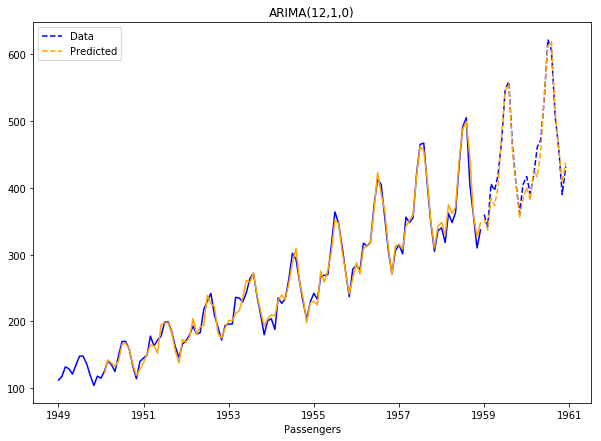

In [10]:
predictions = ar_model.predict(start='1959-01-01', end='1960-12-01', typ='levels')
fittedvalues=ar_model.predict(typ='levels')

plt.figure(figsize=(10,7))
plt.plot(np.exp(log_ts[:'1958-12-01']), color='b')
plt.plot(np.exp(log_ts['1959-01-01':]), color='b', linestyle='--', label='Data' )
plt.plot(np.exp(predictions), color='orange', linestyle='--', label='Predicted')
plt.plot(np.exp(fittedvalues), color='orange')
plt.title('ARIMA(12,1,0)')
plt.legend(loc='best')
plt.xlabel('Passengers')